# Creating synthetic data to mimic the VitaRenal dataset

Power calculation (based on repeated measures ANOVA, N=24, 4 time levels, and 2 equal sized groups, with 80% power and 5% alpha) shows that effects at the higher boundary of small effect sizes and the lower boundary of medium sized effects of Cohen’s d=.50-.55 (ƞ2=.07) can be reliably detected. This calculation allows for the planned linear mixed-model within-between interaction analyses, described at par. 8.3. For the analyses of main effects on the main endpoint/primary outcome (decrease over time on both cognitive biases within whole sample) the power with a N=24 sample size is considerably larger. Previous studies from our team among healthy volunteers with fatigue complaints showed similar effect sizes after less intensive single-session CBM (Pieterse & Bode, 2018). As LMM analyses can account for missing values effectively, partial missingness of datapoints is allowed and does not necessarily affect this power calculation.

- N = 24,
- Repeated measures = 4
- Groups = 2

In [1]:
2 * 4 * 24

192

In [125]:
from pymer4 import Lmer, simulate_lmm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils import diagnostic_plots

In [105]:
number_observations = 4 # amount of observations per group (i.e. user_id)
number_predictors = 10
number_groups = 24 # amount of groups (i.e. user_id)

df, blups, coefficient = simulate_lmm(num_obs=number_observations,
    num_coef=number_predictors,
    num_grps=number_groups,
    coef_vals=None,
    corrs=None,
    grp_sigmas=0.25,
    mus=0.0,
    sigmas=1.0,
    noise_params=(0, 2),
    family='gaussian',
    seed=69420)

df = (df.assign(m00_name= lambda x: np.tile(["m00", "m03", "m06", "m09"], number_groups))
      .assign(diagnosis = np.repeat([0, 1], int(df.shape[0]/2)))
      .rename(columns={"Group": "user_id"}, inplace=False)
      .assign(user_id=lambda x: x["user_id"].astype(int))
      )

In [120]:
# blups

In [106]:
display(df.head()), df.shape

,DV,IV1,IV2,IV3,IV4,IV5,IV6,IV7,IV8,IV9,IV10,user_id,m00_name,diagnosis
0,4.186382,-1.364730,1.199974,1.099795,-1.059749,1.309889,1.624472,0.405392,1.635940,-0.024605,1.977637,1,m00,0
1,-0.334916,0.770099,-1.151767,-0.306428,-0.149539,-0.946221,-0.289248,0.522582,0.068253,0.845945,2.137904,1,m03,0
2,1.118914,1.902625,1.757406,-0.506102,0.717782,0.991267,-0.137597,-0.043067,0.561357,-1.090767,0.464028,1,m06,0
3,-2.826966,-1.305553,0.816688,-0.841455,0.233279,0.196164,-0.853218,-0.743983,-0.949950,-1.227671,-0.664123,1,m09,0
4,-2.015131,-0.268349,0.752977,1.629081,0.020699,0.445079,0.600776,-1.834599,-2.360990,-0.150582,-0.164347,2,m00,0


(None, (96, 14))

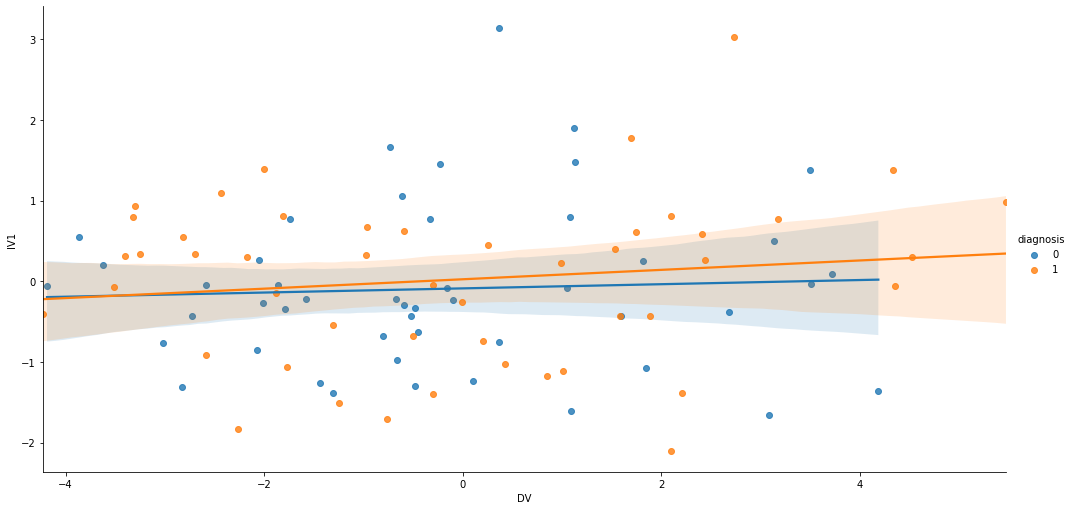

In [107]:
_ = sns.lmplot(data=df, x="DV", y="IV1", hue="diagnosis", height=7, aspect=2)

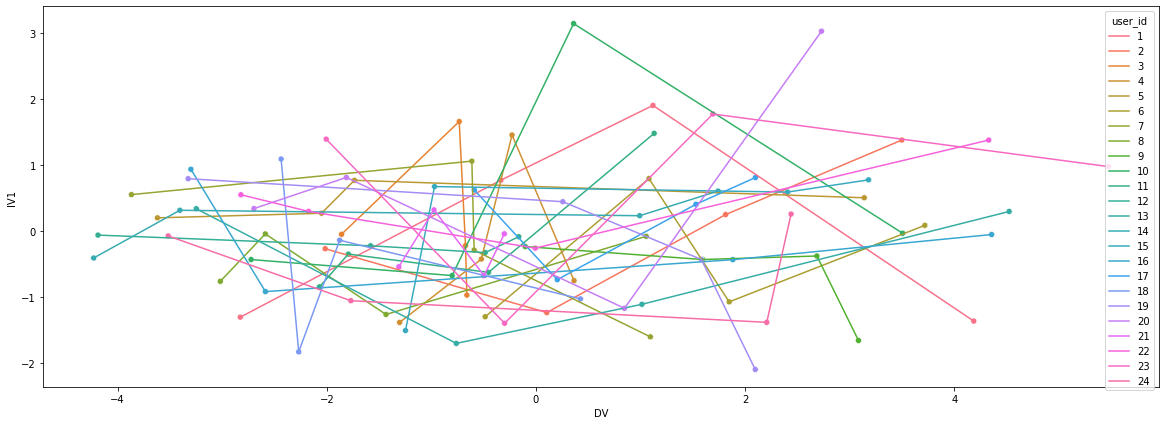

In [108]:
_ = plt.figure(figsize=(20, 7))
_ = sns.lineplot(data=df.assign(user_id=lambda x: x["user_id"].astype("category")), x="DV", y="IV1", hue="user_id")
_ = sns.scatterplot(data=df.assign(user_id=lambda x: x["user_id"].astype("category")), x="DV", y="IV1", hue="user_id", legend=False)

## Specify the predictor list and make 2.5% of the predictor columns np.nans

In [109]:
predictor_list = df.filter(regex="IV").columns.tolist()

# df[predictor_list] = df[predictor_list].mask(np.random.random(df[predictor_list].shape) < .025)

dataLMM = df.dropna()
dataLMM.shape

(96, 14)

In [110]:
feature_collection = " + ".join(predictor_list[-3:])
feature_collection

'IV8 + IV9 + IV10'

## Specify the model with the formula_string as the model syntax

In [111]:
target_name = "DV"

In [121]:
# formula_string = f"{target_name} ~ {feature_collection} + (1 + m00_name|user_id) + (1|diagnosis)"
formula_string = f"{target_name} ~ {feature_collection} + (1|user_id) + (1|m00_name) + (1|diagnosis)"
# formula_string = f"{target_name} ~ {feature_collection} + (1|diagnosis)"
print(formula_string)

model = Lmer(data=dataLMM, formula=formula_string)

DV ~ IV8 + IV9 + IV10 + (1|user_id) + (1|m00_name) + (1|diagnosis)


In [124]:
# dataLMM.info()

## Fit the model

Here you can specify factor levels of categorical features, and what approach you want used for confidence intervals of the coefficients

In [123]:
# fixed_effect_output = model.fit(no_warnings=True, conf_int='profile') #model where the m00_name is not considered an ordered categorical feature
fixed_effect_output = model.fit(factors = {"m00_name": dataLMM["m00_name"].unique().tolist()}, 
                                ordered=True, no_warnings=True, conf_int='profile')

fixed_effect_output

Formula: DV~IV8+IV9+IV10+(1|user_id)+(1|m00_name)+(1|diagnosis)

Family: gaussian	 Inference: parametric

Number of observations: 96	 Groups: {'user_id': 24.0, 'm00_name': 4.0, 'diagnosis': 2.0}

Log-likelihood: -203.640 	 AIC: 407.281

Random effects:

                  Name    Var    Std
user_id    (Intercept)  0.000  0.000
m00_name   (Intercept)  0.000  0.019
diagnosis  (Intercept)  0.000  0.000
Residual                4.015  2.004

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),-0.028,-0.486,0.429,0.208,2.897,-0.135,0.902,
IV8,0.944,0.542,1.346,0.207,91.968,4.548,0.000,***
IV9,0.504,0.125,0.883,0.195,90.424,2.580,0.012,*
IV10,0.373,-0.030,0.775,0.208,91.454,1.797,0.076,.


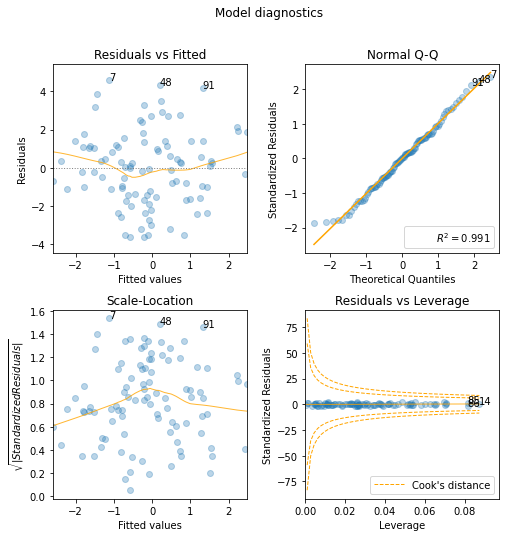

In [126]:
fig, axs = diagnostic_plots(model_fit=model,
                                         X=None,
                                         y=None,
                                         figsize = (8,8),
                                         limit_cooks_plot = False,
                                         subplot_adjust_args={"wspace": 0.3, "hspace": 0.3}
                                        )